In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import Image

sns.set()

# Report 

In [4]:
df = pd.read_csv('R5.csv')

In [57]:
df.describe()

,pages_per_day_samples,age_samples,days_in_yrs_samples
count,150.000000,150.000000,150.000000
mean,52.200000,36.540000,66.280000
std,39.393387,7.485673,49.157755
min,0.000000,21.000000,0.000000
25%,27.000000,31.000000,29.250000
50%,43.000000,36.000000,52.000000
75%,62.000000,41.000000,87.000000
max,250.000000,60.000000,180.000000


The following observations are made:
    
     - there is at least 1 registered person who has not read any page in the last 3 years
     - there is at least 1 registered person who has not taken a license in the last 3 years
    
     - the average number of pages read is 52.2
     - the average age of workers is 36.5
    
     - the maximum number of pages read is 250
     - the oldest registered worker is 60 years old
     - The worker who took the most licenses in 3 years was 180

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


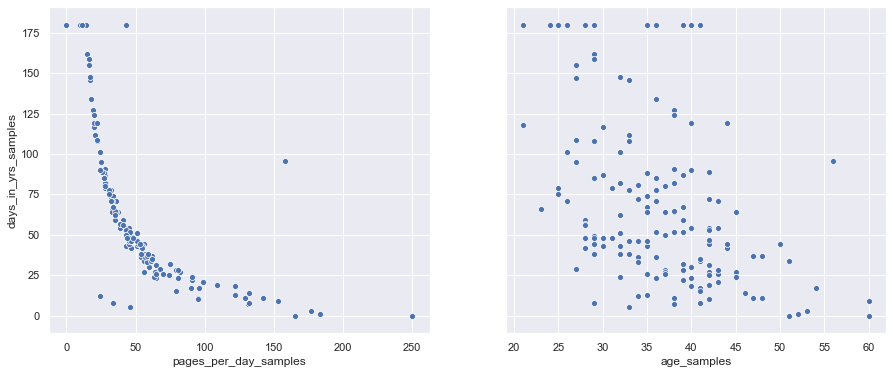

In [58]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
sns.scatterplot(df.pages_per_day_samples,df.days_in_yrs_samples, ax=ax[0])
sns.scatterplot(df.age_samples, df.days_in_yrs_samples, ax=ax[1])
fig.show()

#### We note that the relationship between days_in_yrs_samples and pages_per_day_samples is that of a rational function, that is, of the form y = A / X + B so we proceed to transform it to obtain the relationship between these 2 features in a linear way and to model this relationship with a linear regression

#### We also remove the feature age_samples because we note that it has no correlation with days_in_yrs_samples

In [5]:
del df['age_samples']

## Removing outliers

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


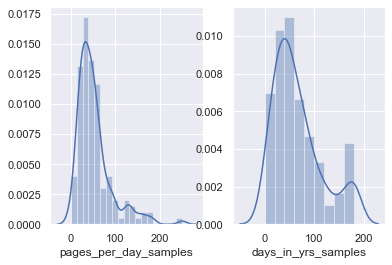

In [60]:
fig, ax = plt.subplots(1,2)
sns.distplot(df.pages_per_day_samples, ax=ax[0])
sns.distplot(df.days_in_yrs_samples, ax=ax[1])
fig.show()

In [6]:
q = df['pages_per_day_samples'].quantile(0.95)
df = df[df['pages_per_day_samples'] < q]

In [7]:
q = df['days_in_yrs_samples'].quantile(0.95)
df = df[df['days_in_yrs_samples'] < q]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


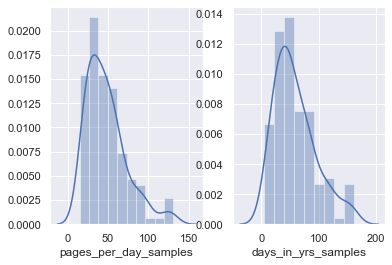

In [63]:
fig, ax = plt.subplots(1,2)
sns.distplot(df.pages_per_day_samples, ax=ax[0])
sns.distplot(df.days_in_yrs_samples, ax=ax[1])
fig.show()

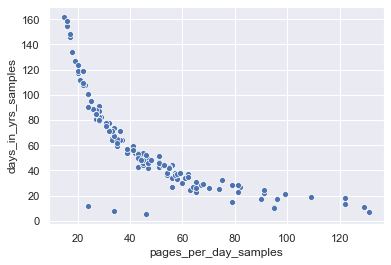

In [64]:
sns.scatterplot(df.pages_per_day_samples, df.days_in_yrs_samples)

We observe outliers that remain, we remove them by hand

In [8]:
#identifying outliers By hand
df[(df['days_in_yrs_samples'] < 20) & (df['pages_per_day_samples'] < 60)]

,pages_per_day_samples,days_in_yrs_samples
13,46,5
16,34,8
145,24,12


In [66]:
#deleting outliers
df.drop([13,16,145], inplace=True)

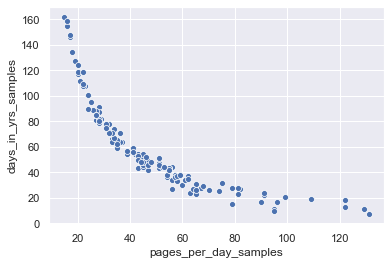

In [67]:
sns.scatterplot(df.pages_per_day_samples, df.days_in_yrs_samples)

## linear transformation 

In [148]:
# We find out that the relationship between 'pages_per_day_samples' and 'days_in_yrs_samples' have the form y = 1 / Ax + B

# when applying 1 / x we must do a zeros treatment, the options are:
# - delete rows that have 0
# - change 0 to 0.001 (where it is observed that if the scale of the dataset is already small in general
# then the replacement should be of a smaller number, for example 0.000000001)
#

df['pages_per_day_samples'].replace(0, 0.00001)
df['pages_per_day_samples_transf'] = 1 / (df.pages_per_day_samples)
#df = df[(df != 0).all(1)] #removing -inf values ( X == 0 ) -> REMUEVO ROW QUE TENGA ALGUN 0

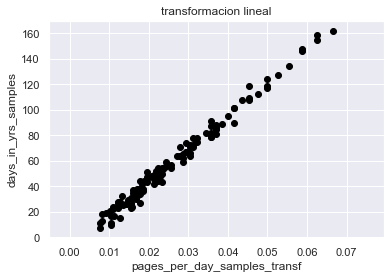

In [69]:
plt.scatter(df.pages_per_day_samples_transf, df.days_in_yrs_samples,  color='black')
plt.xlabel("pages_per_day_samples_transf")
plt.ylabel("days_in_yrs_samples")
plt.title("transformacion lineal")
plt.show()

We note that we were able to transform the relationship of pages_per_day_samples and days_in_yrs_sample into a linear relationship

## Entrenamos modelo 

In [70]:
def print_model_statistics(regr, y_test, y_pred):

    # The coefficients
    print('Coefficients: ', regr.coef_)

    # The intercept_ 
    print('Intercept (Y axis when X = 0): ', regr.intercept_)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: %.2f' % r2)
    
    # Adjusted r2
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
    print('Adjusted r2: %.2f' % adjusted_r2)
    
    #explained_variance_score
    print('explained_variance_score: %.2f' % explained_variance_score(y_test, y_pred))

In [71]:
X = df[[
    'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [72]:
print_model_statistics(regr, y_test, y_pred)

Coefficients:  [2603.9588694]
Intercept (Y axis when X = 0):  -9.294970958161592
Mean squared error: 20.39
Coefficient of determination: 0.98
Adjusted r2: 0.98
explained_variance_score: 0.98


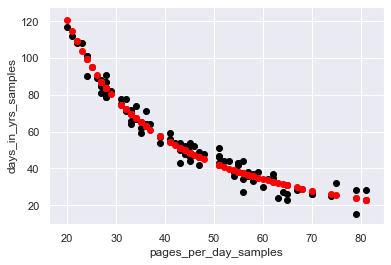

In [109]:
fc = 2603/(df.pages_per_day_samples) + -9.2
plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.xlabel("pages_per_day_samples")
plt.ylabel("days_in_yrs_samples")
plt.show()

In [74]:
q = df['pages_per_day_samples'].quantile(0.90)
df = df[df['pages_per_day_samples'] < q]

q = df['days_in_yrs_samples'].quantile(0.90)
df = df[df['days_in_yrs_samples'] < q]

In [75]:
print_model_statistics(regr, y_test, y_pred)

Coefficients:  [2603.9588694]
Intercept (Y axis when X = 0):  -9.294970958161592
Mean squared error: 20.39
Coefficient of determination: 0.98
Adjusted r2: 0.98
explained_variance_score: 0.98


In [101]:
#ejemplo de uso

def transformar_valor(pages_per_day_samples):
 return 1/pages_per_day_samples

pages_per_day_samples = 100
x = transformar_valor(pages_per_day_samples)
regr.predict([[x]])

array([16.74461774])

The function that represents the relationship between pages_per_day_samples and days_in_yrs_samples is:
#### days_in_yrs_samples = 2603 / pages_per_day_samples + -9.2
Because days_in_yrs_samples is inversely proportional to pages_per_day_samples we can see that if a worker reads very few sheets per day, when reading more sheets, the number of licenses taken will drop quickly. Likewise, workers who already read many pages per day will not present a significant drop in the licenses taken if they read more pages.